In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from WindPy import w
%matplotlib inline

In [2]:
sns.set_style("darkgrid")

In [3]:
w.start()

Welcome to use Wind Quant API for Python (WindPy)!
You can use w.menu to help yourself to create commands(WSD,WSS,WST,WSI,WSQ,...)!

COPYRIGHT (C) 2016 WIND HONGHUI INFORMATION & TECHKNOLEWDGE CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [4]:
DATA_DIR = "C:/Users/jgtzsx01/Documents/workspace/data/factor-investing/"
STOCK_FILE = "%s/stock.xlsx"%(DATA_DIR)
BOND_FILE = "%s/bond.xlsx"%(DATA_DIR)
HK_FILE = "%s/hk.xlsx"%(DATA_DIR)
START_DATE = "2005-01-01"
END_DATE = "2016-12-31"
years = [str(y) for y in range(int(START_DATE[:4])+1, int(END_DATE[:4])+1)]

In [5]:
stock_df = pd.read_excel(STOCK_FILE)

In [6]:
stock_df.set_index('code', inplace=True)

In [7]:
stock_df

,name
code,
CI005001.WI,石油石化
CI005002.WI,煤炭
CI005003.WI,有色金属
CI005004.WI,电力及公用事业
CI005005.WI,钢铁
CI005006.WI,基础化工
CI005007.WI,建筑
CI005008.WI,建材
CI005009.WI,轻工制造


In [8]:
bond_df = pd.read_excel(BOND_FILE)

In [9]:
bond_df.set_index('code', inplace=True)

In [10]:
bond_df

,name
code,
038.CS,中债国债
042.CS,中债金融债券
078.CS,中债企业债AAA
079.CS,中债企业债AA+
080.CS,中债企业债AA
081.CS,中债企业债AA-
053.CS,中债短融
H11025.CSI,货币基金
098.CS,中债银行间资产支持证券


In [11]:
hk_df = pd.read_excel(HK_FILE)

In [12]:
hk_df.set_index('code', inplace=True)

In [13]:
hk_df

,name
code,
HSESI.HI,恒生能源业
HSCIMT.HI,恒生原材料业
HSGSI.HI,恒生工业
HSCISV.HI,恒生消费者服务业
HSTSI.HI,恒生电讯业
HSUSI.HI,恒生公用事业
HSFSI.HI,恒生金融业
HSPCSI.HI,恒生地产建筑业
HSITSI.HI,恒生资讯科技业


In [14]:
def wind2df(raw_data):
    dic = {}
    for data, field in zip(raw_data.Data, raw_data.Fields):
        dic[str(field.lower())] = data
    return pd.DataFrame(dic, index=raw_data.Times)

In [15]:
def get_ranks(asset_df, groups=5):
    length = asset_df.shape[0]
    leng_group = length / groups
    if length % groups > groups / 2:
        leng_group += 1
    ranks = []
    for i in range(1, groups):
        ranks += [i]*leng_group
    ranks += [groups]*(length-len(ranks))
    return ranks

In [16]:
def get_asset_return(asset_df):
    res_df = asset_df.copy()
    for asset in asset_df.index:
        data = w.wsd(asset, 'close', START_DATE, END_DATE)
        df = wind2df(data)
        df = df.resample('A').last()
        df['return'] = df['close'].pct_change()
        for ind in df.index[1:]:
            year = ind.year
            res_df.loc[asset, "%d return"%(year)] = df.loc[ind, 'return']
    return res_df

In [17]:
def get_factor(asset_df, factor, order=False):
    """
    order为False数值越小得分越高，反之越大得分越高
    """
    res_df = asset_df.copy()
    for asset in asset_df.index:
        data = w.wsd(asset, factor, START_DATE, END_DATE)
        df = wind2df(data)
        df = df.resample('A').last()
        for ind in df.index[:-1]:
            year = ind.year + 1
            if not order:
                res_df.loc[asset, "%d %s"%(year, factor)] = df.loc[ind, factor]
            else:
                res_df.loc[asset, "%d %s"%(year, factor)] = df.loc[ind, factor] * -1.0
    return res_df

In [38]:
def get_group_return(asset_df, factors, weights, years, ranks):
    assert(len(factors) == len(weights))
    weights = np.array(weights) * 1.0 / sum(weights)
    ranks = np.array(ranks)
    groups = max(ranks)
    group_df = pd.DataFrame(index=range(1, groups+1))
    for y in years:
        features = ["%s %s"%(y, f) for f in factors]
        rcol = "%s return"%(y)
        features.append(rcol)
        df = asset_df[features]
        for f, w in zip(factors, weights):
            df = df.sort_values(by="%s %s"%(y, f), ascending=False) # 值越小越有价值
            df['%s rank'%(f)] = ranks * w

        features = ["%s rank"%(f) for f in factors]
        df["sum rank"] = df[features].sum(axis=1)
        df = df.sort_values(by="sum rank", ascending=True)
        df["rank"] = ranks

        group_df[rcol] = df.groupby('rank').mean()[rcol]
    return group_df

# 添加各指数每年的收益率

In [19]:
stock_df = get_asset_return(stock_df)

In [20]:
stock_df

,name,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
code,,,,,,,,,,,,
CI005001.WI,石油石化,0.971607,1.250021,-0.647466,0.745862,-0.051423,-0.238961,-0.003725,0.072181,0.242092,0.030286,-0.005567
CI005002.WI,煤炭,0.413547,2.921693,-0.670935,1.728082,-0.046792,-0.255005,-0.034340,-0.402956,0.321337,-0.077129,0.003619
CI005003.WI,有色金属,1.448112,2.904751,-0.766983,1.814234,0.197597,-0.416105,0.128040,-0.297540,0.462701,0.161350,-0.076686
CI005004.WI,电力及公用事业,0.335519,1.797765,-0.547814,0.511284,-0.087456,-0.207423,0.095577,0.134786,0.631829,0.181358,-0.173497
CI005005.WI,钢铁,0.949575,1.881816,-0.703802,0.995917,-0.255843,-0.286106,-0.028838,-0.164872,0.692943,-0.064019,-0.069621
CI005006.WI,基础化工,0.517131,2.203531,-0.597869,1.003477,0.009357,-0.309832,-0.011644,0.084861,0.333501,0.804191,-0.101393
CI005007.WI,建筑,0.601445,2.182330,-0.479882,0.392633,-0.031397,-0.299807,0.219326,-0.099633,0.998993,0.157789,-0.026947
CI005008.WI,建材,0.883000,1.999232,-0.599359,1.247634,0.142402,-0.314670,0.026386,-0.061629,0.373458,0.438761,-0.078345
CI005009.WI,轻工制造,0.502172,1.728489,-0.651889,1.184418,-0.034839,-0.264304,-0.015189,0.238757,0.309475,0.971079,-0.134922


# book-to-price

In [21]:
book_to_price = "pb_lf"

In [22]:
stock_df = get_factor(stock_df, book_to_price)

In [23]:
stock_df.head()

,name,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,...,2007 pb_lf,2008 pb_lf,2009 pb_lf,2010 pb_lf,2011 pb_lf,2012 pb_lf,2013 pb_lf,2014 pb_lf,2015 pb_lf,2016 pb_lf
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.971607,1.250021,-0.647466,0.745862,-0.051423,-0.238961,-0.003725,0.072181,0.242092,...,3.2952,8.0949,2.3717,3.2123,2.2725,1.7142,1.5594,1.2995,1.6478,1.3159
CI005002.WI,煤炭,0.413547,2.921693,-0.670935,1.728082,-0.046792,-0.255005,-0.034340,-0.402956,0.321337,...,2.1207,8.9531,2.1462,4.4302,3.4280,2.4088,2.0163,1.1579,1.4814,1.2624
CI005003.WI,有色金属,1.448112,2.904751,-0.766983,1.814234,0.197597,-0.416105,0.128040,-0.297540,0.462701,...,3.2056,9.3450,1.9680,5.5836,5.5466,2.7946,3.0837,2.0905,2.9622,3.3440
CI005004.WI,电力及公用事业,0.335519,1.797765,-0.547814,0.511284,-0.087456,-0.207423,0.095577,0.134786,0.631829,...,1.9855,4.7725,2.1811,2.6793,2.3762,1.8894,1.8481,1.7292,2.5202,2.7185
CI005005.WI,钢铁,0.949575,1.881816,-0.703802,0.995917,-0.255843,-0.286106,-0.028838,-0.164872,0.692943,...,1.7268,4.0424,1.0278,2.1858,1.4810,1.0266,1.0155,0.8637,1.4645,1.6569


# earnings-to-price

In [24]:
earnings_to_price = "pe_ttm"

In [25]:
stock_df = get_factor(stock_df, earnings_to_price)

In [26]:
stock_df.head()

,name,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,...,2007 pe_ttm,2008 pe_ttm,2009 pe_ttm,2010 pe_ttm,2011 pe_ttm,2012 pe_ttm,2013 pe_ttm,2014 pe_ttm,2015 pe_ttm,2016 pe_ttm
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.971607,1.250021,-0.647466,0.745862,-0.051423,-0.238961,-0.003725,0.072181,0.242092,...,18.805600,38.973100,18.2971,23.218300,15.917000,11.576400,14.661600,11.185100,14.963800,37.050500
CI005002.WI,煤炭,0.413547,2.921693,-0.670935,1.728082,-0.046792,-0.255005,-0.034340,-0.402956,0.321337,...,14.730700,66.176300,10.6438,28.837000,19.775900,13.290000,13.412700,11.176700,19.357401,71.472000
CI005003.WI,有色金属,1.448112,2.904751,-0.766983,1.814234,0.197597,-0.416105,0.128040,-0.297540,0.462701,...,17.817499,48.537998,14.7880,40272.605469,74.926498,23.431299,54.503799,69.278503,62.505901,5811.768555
CI005004.WI,电力及公用事业,0.335519,1.797765,-0.547814,0.511284,-0.087456,-0.207423,0.095577,0.134786,0.631829,...,22.083600,46.468600,74.4943,55.614600,30.512500,25.222700,22.138000,12.694700,19.436300,22.991300
CI005005.WI,钢铁,0.949575,1.881816,-0.703802,0.995917,-0.255843,-0.286106,-0.028838,-0.164872,0.692943,...,15.194800,26.824400,6.7783,1203.553101,21.602900,18.647301,185.050293,87.065201,85.755898,3990.236084


# cash flow-to-price

In [27]:
cashflow_to_price = "pcf_ocf_ttm"

In [28]:
stock_df = get_factor(stock_df, cashflow_to_price)

In [29]:
stock_df.head()

,name,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,...,2007 pcf_ocf_ttm,2008 pcf_ocf_ttm,2009 pcf_ocf_ttm,2010 pcf_ocf_ttm,2011 pcf_ocf_ttm,2012 pcf_ocf_ttm,2013 pcf_ocf_ttm,2014 pcf_ocf_ttm,2015 pcf_ocf_ttm,2016 pcf_ocf_ttm
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.971607,1.250021,-0.647466,0.745862,-0.051423,-0.238961,-0.003725,0.072181,0.242092,...,9.7296,21.6425,12.4578,9.6609,6.4702,5.8472,6.4392,5.2866,5.8901,5.4722
CI005002.WI,煤炭,0.413547,2.921693,-0.670935,1.728082,-0.046792,-0.255005,-0.034340,-0.402956,0.321337,...,8.5690,36.6631,7.0945,17.7707,12.4266,7.6356,10.2421,8.1255,8.8450,16.9510
CI005003.WI,有色金属,1.448112,2.904751,-0.766983,1.814234,0.197597,-0.416105,0.128040,-0.297540,0.462701,...,20.5339,53.5655,15.7350,36.9258,125.2548,25.6045,29.7518,18.8073,20.8052,25.5566
CI005004.WI,电力及公用事业,0.335519,1.797765,-0.547814,0.511284,-0.087456,-0.207423,0.095577,0.134786,0.631829,...,7.6135,19.9906,13.4183,9.6019,8.9138,7.2517,5.6545,4.1582,7.0722,8.6305
CI005005.WI,钢铁,0.949575,1.881816,-0.703802,0.995917,-0.255843,-0.286106,-0.028838,-0.164872,0.692943,...,6.3090,20.4673,7.9127,8.9704,12.1254,8.1295,5.9984,4.5987,6.5634,11.3711


# sales-to-enterprise value

In [30]:
sales_to_enterprise = "ps_ttm"

In [31]:
stock_df = get_factor(stock_df, sales_to_enterprise)

In [32]:
stock_df.head()

,name,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,...,2007 ps_ttm,2008 ps_ttm,2009 ps_ttm,2010 ps_ttm,2011 ps_ttm,2012 ps_ttm,2013 ps_ttm,2014 ps_ttm,2015 ps_ttm,2016 ps_ttm
code,,,,,,,,,,,,,,,,,,,,,
CI005001.WI,石油石化,0.971607,1.250021,-0.647466,0.745862,-0.051423,-0.238961,-0.003725,0.072181,0.242092,...,0.8488,4.1621,0.9799,1.8321,0.9242,0.5957,0.5100,0.4223,0.5722,0.6015
CI005002.WI,煤炭,0.413547,2.921693,-0.670935,1.728082,-0.046792,-0.255005,-0.034340,-0.402956,0.321337,...,1.6829,10.7269,1.9832,4.6274,2.7420,1.7344,1.3492,0.8020,1.3161,1.4207
CI005003.WI,有色金属,1.448112,2.904751,-0.766983,1.814234,0.197597,-0.416105,0.128040,-0.297540,0.462701,...,1.3710,4.4722,0.9460,3.5036,2.5037,1.1121,1.1754,0.7703,1.0938,1.3342
CI005004.WI,电力及公用事业,0.335519,1.797765,-0.547814,0.511284,-0.087456,-0.207423,0.095577,0.134786,0.631829,...,2.1118,5.3542,1.8857,2.6068,1.9127,1.3287,1.3737,1.3416,2.1839,2.9337
CI005005.WI,钢铁,0.949575,1.881816,-0.703802,0.995917,-0.255843,-0.286106,-0.028838,-0.164872,0.692943,...,0.7737,1.6279,0.3488,0.9615,0.5189,0.3296,0.3465,0.3177,0.5100,0.7817


# 获取每年分组后的收益

In [33]:
ranks = get_ranks(stock_df)

In [39]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise]
weights = [1, 1, 1, 1]

In [40]:
group_df = get_group_return(stock_df, factors, weights, years, ranks)

In [41]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,1.222793,1.482542,-0.619751,1.098394,0.202687,-0.366658,-0.027159,0.446141,0.328856,0.851662,-0.261131
2,0.794324,1.653193,-0.617739,0.947305,0.192710,-0.253120,-0.013667,0.104661,0.396351,0.408665,-0.139912
3,0.725301,2.069517,-0.635186,0.969075,-0.031570,-0.288106,-0.003293,0.085848,0.453402,0.835121,-0.110931
4,0.898464,1.696802,-0.566917,1.376035,-0.047984,-0.227830,0.123078,0.031640,0.623133,0.361817,-0.108071
5,0.752962,1.884837,-0.625022,1.332018,-0.063616,-0.289769,0.095207,0.109366,0.582506,0.082580,-0.025270


In [42]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

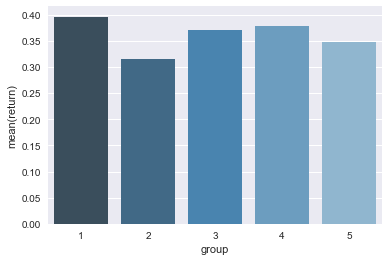

In [43]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [45]:
group_df.to_excel("%s/value.xlsx"%(DATA_DIR))

# 加入momentum

In [46]:
for stock in stock_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df = df.resample('BMS').first()
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=12).mean()
    df = df.resample('BAS').first()
    for ind in df.index[1:]:
        year = ind.year
        stock_df.loc[stock, "%d momentum"%(year)] = -df.loc[ind, "avg return"]

In [47]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum"]
weights = [1, 1, 1, 1, 4]

In [48]:
ranks = get_ranks(stock_df)

In [49]:
group_df = get_group_return(stock_df, factors, weights, years, ranks)

In [50]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.417388,1.789205,-0.618835,1.161880,0.094340,-0.229641,-0.025109,0.459414,0.478293,0.704541,-0.077085
2,1.130898,1.746196,-0.581566,1.103952,0.078101,-0.278553,0.028744,0.145807,0.447226,0.923737,-0.119183
3,0.783511,1.783657,-0.655425,1.341416,0.058019,-0.269970,0.010224,0.086215,0.686422,0.625847,-0.209320
4,0.976962,1.693370,-0.626337,1.077939,0.014349,-0.354829,0.043547,-0.022630,0.303828,0.106936,-0.143637
5,1.151511,1.752388,-0.573935,0.978764,0.021628,-0.293033,0.121072,0.108748,0.445675,0.198025,-0.110253


In [51]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

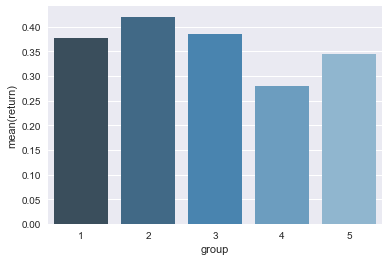

In [52]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [54]:
group_df.to_excel("%s/value_momentum.xlsx"%(DATA_DIR))

# 加入波动率

In [138]:
for stock in stock_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df['return'] = df.pct_change()
    df['volatility'] = df['return'].rolling(window=243).std() * np.sqrt(243)
    df = df.resample('BAS').first()
    for ind in df.index[1:]:
        year = ind.year
        stock_df.loc[stock, "%d volatility"%(year)] = df.loc[ind, "volatility"]

In [139]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum", "volatility"]
weights = [1, 1, 1, 1, 4, 4]

In [151]:
ranks = get_ranks(stock_df, 10)

In [152]:
group_df = get_group_return(stock_df, factors, weights, years, ranks)

In [153]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': group_df['2016 return']})

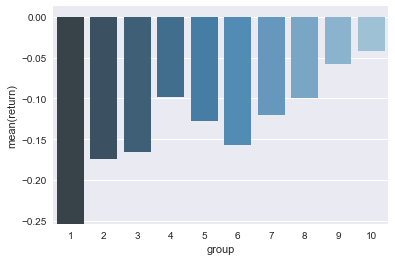

In [154]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

In [144]:
group_df.to_excel("%s/value_momentum_volatility.xlsx"%(DATA_DIR))

# 尝试港股

In [55]:
hk_df = get_asset_return(hk_df)

In [56]:
hk_df = get_factor(hk_df, book_to_price)

In [57]:
hk_df = get_factor(hk_df, earnings_to_price)

In [58]:
hk_df = get_factor(hk_df, cashflow_to_price)

In [59]:
hk_df = get_factor(hk_df, sales_to_enterprise)

In [60]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise]
weights = [1, 1, 1, 1]

In [61]:
ranks = get_ranks(hk_df)

In [63]:
group_df = get_group_return(hk_df, factors, weights, years, ranks)

In [64]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.744535,0.214120,-0.572021,0.368132,0.011486,-0.214144,0.233222,0.269726,-0.108203,0.060267,0.058958
2,0.145912,0.481753,-0.583149,0.559339,0.078963,-0.226198,0.169787,0.405917,-0.024344,-0.160272,-0.019107
3,0.499137,0.471149,-0.520250,1.411913,0.142432,-0.435526,0.196006,-0.100526,0.062867,-0.009524,-0.067866
4,0.391787,0.503196,-0.557549,0.751840,0.148867,-0.113068,0.198174,0.017316,0.029287,-0.075689,-0.092508
5,0.373656,0.453564,-0.456744,0.821676,0.169209,-0.129451,0.209667,-0.076393,-0.051277,-0.175240,0.111510


In [67]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

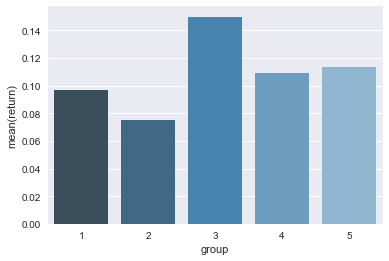

In [69]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [70]:
group_df.to_excel("%s/hk_value.xlsx"%(DATA_DIR))

In [71]:
for stock in hk_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df = df.resample('BMS').first()
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=12).mean()
    df = df.resample('BAS').first()
    for ind in df.index[1:]:
        year = ind.year
        hk_df.loc[stock, "%d momentum"%(year)] = -df.loc[ind, "avg return"]

In [72]:
ranks = get_ranks(hk_df)

In [73]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum"]
weights = [1, 1, 1, 1, 4]

In [74]:
group_df = get_group_return(hk_df, factors, weights, years, ranks)

In [75]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

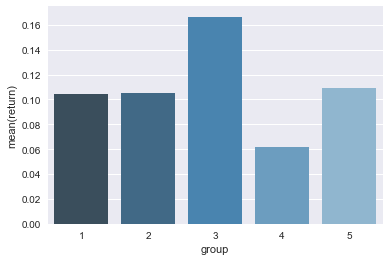

In [76]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")

# 尝试债券

In [77]:
bond_df = get_asset_return(bond_df)

In [78]:
for bond in bond_df.index:
    data = w.wsd(bond, 'ytm_b', START_DATE, END_DATE, "returnType=1")
    df = wind2df(data)
    df = df.resample('A').last()
    for ind in df.index[:-1]:
        year = ind.year + 1
        if df.loc[ind, "ytm_b"] == None:
            bond_df.loc[bond, "%d %s"%(year, "ytm_b")] = df.loc[ind, "ytm_b"]
        else:
            bond_df.loc[bond, "%d %s"%(year, "ytm_b")] = df.loc[ind, "ytm_b"] * -1.0

In [79]:
factors = ["ytm_b"]
weights = [1]

In [80]:
ranks = get_ranks(bond_df)

In [81]:
group_df = get_group_return(bond_df, factors, weights, years, ranks)

In [82]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.025782,0.005575,0.114136,0.000872,0.023668,0.057968,0.024825,-0.022285,0.113997,0.080682,0.013398
2,0.024943,-0.012726,0.147773,-0.002498,0.028042,0.046466,0.050319,0.022730,0.087130,0.078131,0.021887
3,NaN,NaN,0.172772,0.013448,0.053269,0.033452,0.095906,0.025111,0.118834,0.110227,0.027661
4,0.018892,0.033564,0.098732,0.013328,0.044265,0.027810,0.083803,0.036456,0.082808,0.074852,0.034225
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026108


In [92]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': group_df['2016 return']})

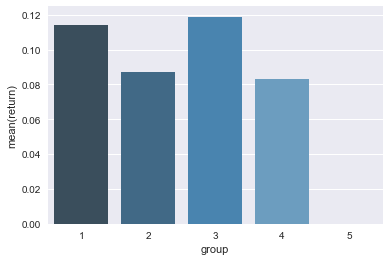

In [93]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")
# vals = ax.get_yticks()
# ax.set_yticklabels(['{:3.2f}%'.format(x*100) for x in vals])

In [94]:
group_df.to_excel("%s/bond_value.xlsx"%(DATA_DIR))

# 尝试某一行业

In [95]:
ind_df = pd.read_excel(u"%s/CS家电.xlsx"%(DATA_DIR))

In [96]:
ind_df.drop(ind_df.index[-2:], inplace=True)

In [97]:
ind_df.set_index('code', inplace=True)

In [98]:
ind_df = get_asset_return(ind_df)

In [99]:
ind_df = get_factor(ind_df, book_to_price)

In [100]:
ind_df = get_factor(ind_df, earnings_to_price)

In [101]:
ind_df = get_factor(ind_df, cashflow_to_price)

In [102]:
ind_df = get_factor(ind_df, sales_to_enterprise)

In [122]:
for stock in ind_df.index:
    data = w.wsd(stock, 'close', START_DATE, END_DATE)
    df = wind2df(data)
    df = df.resample('BMS').first()
    df['return'] = df.pct_change()
    df['avg return'] = df['return'].rolling(window=12).mean()
    df = df.resample('BAS').first()
    for ind in df.index[1:]:
        year = ind.year
        ind_df.loc[stock, "%d momentum"%(year)] = -df.loc[ind, "avg return"]

In [123]:
ind_df.dropna(inplace=True)

In [124]:
ranks = get_ranks(ind_df)

In [125]:
factors = [book_to_price, earnings_to_price, cashflow_to_price, sales_to_enterprise, "momentum"]
weights = [1, 1, 1, 1, 4]

In [126]:
group_df = get_group_return(ind_df, factors, weights, years, ranks)

In [127]:
group_df

,2006 return,2007 return,2008 return,2009 return,2010 return,2011 return,2012 return,2013 return,2014 return,2015 return,2016 return
1,0.609074,1.018756,-0.622267,1.671185,0.243732,-0.319375,-0.313964,0.258294,0.385109,0.195003,-0.036678
2,0.082450,1.123733,-0.703987,1.200896,-0.052706,-0.406732,0.190612,0.387421,0.418729,0.363804,0.029208
3,0.777729,1.374818,-0.443217,1.460151,-0.191410,-0.286405,0.153129,0.220887,0.090856,0.452130,-0.147127
4,0.024180,1.255304,-0.480770,1.401106,0.298157,-0.520515,-0.060099,0.495962,0.187753,0.278960,0.112974
5,0.173021,2.025490,-0.645504,1.622898,0.061720,-0.434479,0.062563,0.180400,0.082978,0.271250,-0.072522


In [128]:
res = group_df.mean(axis=1)
data = pd.DataFrame({'group': res.index, 'return': res.values})

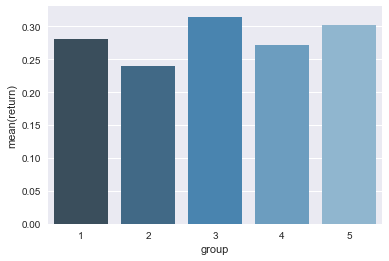

In [129]:
ax = sns.barplot(x='group', y='return', data=data, palette="Blues_d")